In [1]:
%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import torch as t
import numpy as np
from torch.distributions import Categorical, Normal, Independent, MixtureSameFamily
from matplotlib import pyplot as plt

In [38]:
def create_mixture(n_components: int, n_dims: int):
    mix = Categorical(t.rand(n_components,))
    comp = Independent(Normal(t.rand(n_components, n_dims) * 30 - 15, 1 + t.randn(n_components, n_dims).exp()), 1)
    return MixtureSameFamily(mix, comp)


def to_numpy(tensor: t.Tensor):
    return tensor.detach().cpu().numpy()


def to_tensor(array: np.ndarray):
    return t.tensor(array).cuda().float()


def contour_plot(distribution):
    V = 20
    xs = t.linspace(-V, V)
    ys = t.linspace(-V, V)
    XY = t.stack(t.meshgrid(xs, ys), -1)
    probs = mixture.log_prob(XY).exp()
    plt.contour(to_numpy(XY[:, :, 0]), to_numpy(XY[:, :, 1]), to_numpy(probs), levels=40, zorder=0)

In [39]:
class GaussianKernel:
    def __init__(self, sigma: float = 1.):
        self.sigma = sigma
        
    def __call__(self, x1, x2):
        return (-.5 * t.norm(x1[:, None, :] - x2[None, :, :], dim=-1)**2 / self.sigma).exp()

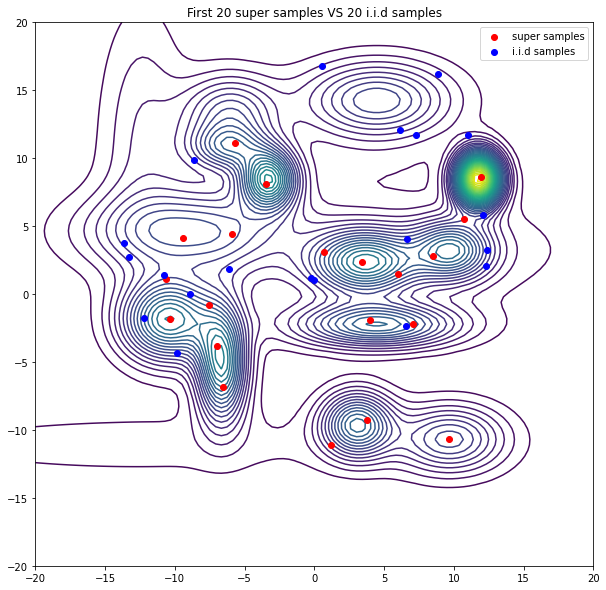

In [41]:
import numpy as np
from tqdm.autonotebook import trange


def herd(pool: t.Tensor, init: t.Tensor, kernel_expects: t.Tensor, kernel, n_samples: int):
    is_taken = t.zeros(len(pool), dtype=t.bool, device=pool.device)
    history = []
    second_term = kernel(pool, init).sum(1)
    
    for i in trange(len(init), n_samples, leave=False, desc='herd'):
        loss = kernel_expects - second_term / (i + 1)
        masked = t.where(is_taken, t.full_like(loss, -np.inf, device=loss.device), loss)
        best_ind = t.argmax(masked)
        
        is_taken[best_ind] = True
        history.append(best_ind)
        second_term = second_term + kernel(pool, pool[best_ind][None]).squeeze(1)
    
    history = t.tensor(history)
    herded = t.cat([init, pool[history]], 0)
        
    return herded


def impirical_kernel_expectation(pool: t.Tensor, kernel, memory_limit: int = 2**22):
    batch_sz = memory_limit // len(pool)
    result = t.zeros(len(pool), device=pool.device)
    for i in trange(0, len(pool), batch_sz, leave=False, desc='kernel expectation'):
        result[i : i + batch_sz] = kernel(pool[i : i + batch_sz], pool).mean(1)
    return result

mixture = create_mixture(20, 2)
kernel = GaussianKernel()
init = mixture.sample([3]).cuda()
pool = mixture.sample([2**15]).cuda()
herded = herd(pool, init, impirical_kernel_expectation(pool, kernel), kernel, 3000)

plt.figure(figsize=(10, 10))
contour_plot(mixture)
plt.scatter(*to_numpy(herded[:20]).T, c='r', label='super samples', zorder=1)
plt.scatter(*to_numpy(pool[:20]).T, c='b', label='i.i.d samples', zorder=1)
plt.title('First 20 super samples VS 20 i.i.d samples')
plt.legend()
plt.show()

# Imperical Distribution Matching

5D gaussian mixture

$\mathcal{D} = 10^5$ i.i.d samples -- imperical distribution

4 test functions

#### Test statistics

In [51]:
class Moment:
    def __init__(self, p):
        self.p = p
        
    @property
    def name(self):
        return f'$\phi(x) = x^{self.p}$'
        
    def __call__(self, Xs):
        return Xs**self.p
    
    def true(self, mixture):
        probs = mixture._mixture_distribution.probs[:, None]
        mus = mixture._component_distribution.base_dist.loc
        sigmas = mixture._component_distribution.base_dist.scale
        
        if self.p == 1:
            components = mus
        elif self.p == 2:
            components = mus**2 + sigmas**2
        elif self.p == 3:
            components = mus**3 + 3 * mus * sigmas**2
        else:
            raise ValueError(f"Illegal moment {self.p}")
            
        return (probs * components).sum(0)
    
    
class Sin:
    def __call__(self, Xs):
        return t.sin(Xs)
    
    @property
    def name(self):
        return f'$\phi(x) = \sin(x)$'

    
    def true(self, mixture):
        probs = mixture._mixture_distribution.probs[:, None]
        mus = mixture._component_distribution.base_dist.loc
        sigmas = mixture._component_distribution.base_dist.scale

        components = t.sin(mus) * t.exp(-sigmas**2 / 2)
        
        return (probs * components).sum(0)
    
    
def sin_expectation(Xs):
    return np.sin(Xs).mean(0)

def error(true, pred):
    return (t.norm(true - pred)**2 / len(true))

def cumulative_error(true, pred):
    cum_mean = t.cumsum(pred, dim=0) / (1 + t.arange(len(pred), device=pred.device))[:, None]
    return (t.norm(cum_mean - true[None, :], dim=1)**2 / len(true))**.5

In [44]:
mixture = create_mixture(10, 3)
D = mixture.sample([10**5]).cuda()

In [45]:
kernel = GaussianKernel(10)
init = mixture.sample([3]).cuda()

herded = herd(D, init, impirical_kernel_expectation(D, kernel), kernel, 10**5 // 2)

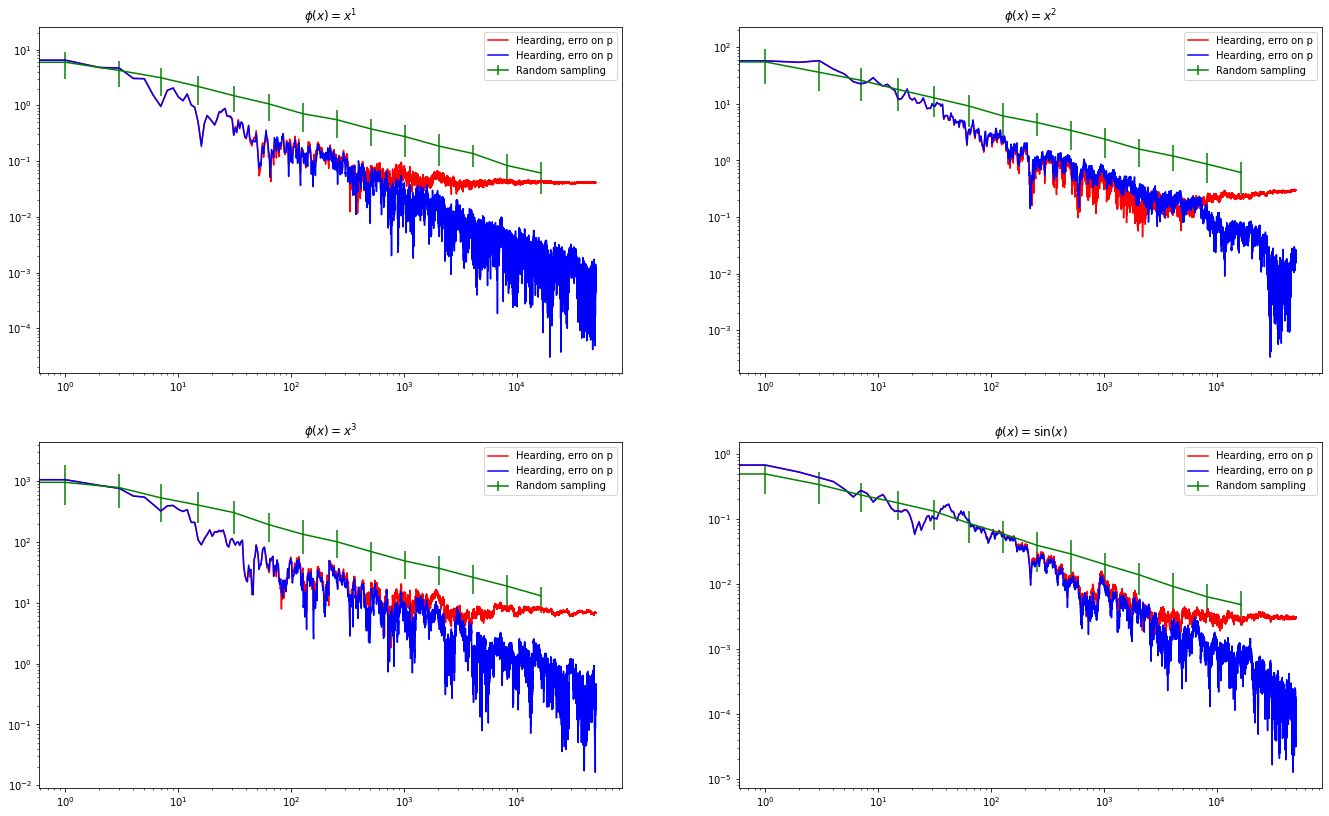

In [52]:
def evaluate_on_function(mixture, D, herded, function, ax):
    true_p = function.true(mixture).cuda()
    true_D = function(D).mean(0)
    
    N_IID_P = 100
    iid_p = t.zeros(N_IID_P, len(herded), device=herded.device)
    for i in trange(N_IID_P, desc='iid on p', leave=False):
        iid_p[i, :] = cumulative_error(true_p, function(mixture.sample([len(herded)]).cuda()))
        
#     plt.figure(figsize=(15, 15))

    iid_p_np = to_numpy(iid_p)
    inds = 2**np.arange(0, int(np.log2(len(herded)))) - 1
    subvalues = iid_p_np[:, inds]

    ys = subvalues.mean(0)
    y_err_up = ys - np.quantile(subvalues, 0.9, axis=0)
    y_err_low = np.quantile(subvalues, 0.1, axis=0) - ys
    ax.errorbar(inds, ys, np.stack([y_err_up, y_err_low], 0), c='g', label='Random sampling')

    ax.plot(to_numpy(cumulative_error(true_p, function(herded))), label='Hearding, erro on p', c='r')
    ax.plot(to_numpy(cumulative_error(true_D, function(herded))), label='Hearding, erro on p', c='b')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
#     plt.show()
    ax.set_title(function.name)
    
FUNCTIONS = [Moment(i) for i in range(1, 4)] + [Sin()]

fig, axs = plt.subplots(2, 2, figsize=(23, 14))
axs = axs.flatten()

for i, function in enumerate(FUNCTIONS):
    evaluate_on_function(mixture, D, herded, function, axs[i])

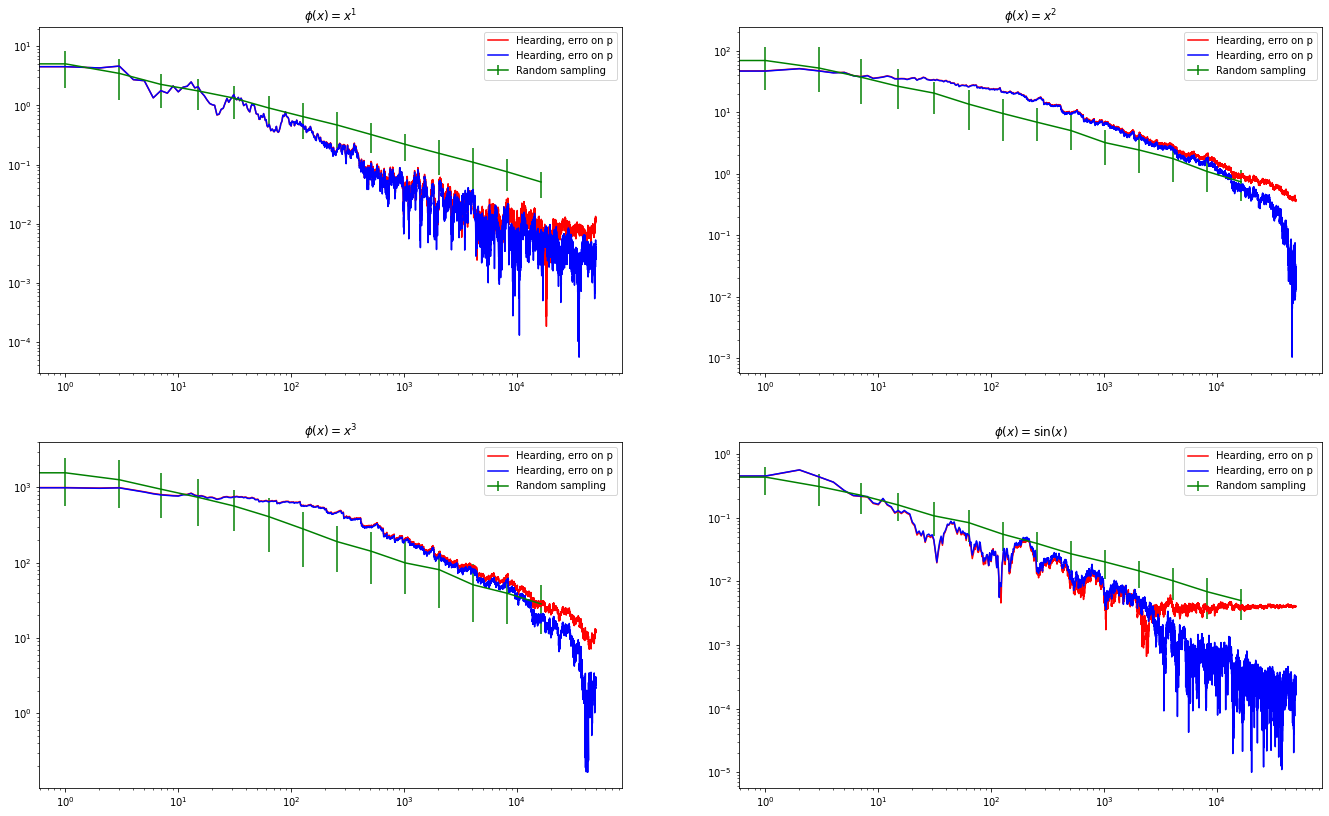

In [69]:
mixture = create_mixture(10, 3)
D = mixture.sample([10**5]).cuda()
kernel = GaussianKernel(1)
init = mixture.sample([3]).cuda()

herded = herd(D, init, impirical_kernel_expectation(D, kernel), kernel, 10**5 // 2)

FUNCTIONS = [Moment(i) for i in range(1, 4)] + [Sin()]

fig, axs = plt.subplots(2, 2, figsize=(23, 14))
axs = axs.flatten()

for i, function in enumerate(FUNCTIONS):
    evaluate_on_function(mixture, D, herded, function, axs[i])

#### Bayesian Posterior

@ UCI spambase (4601 samples, 3000 to train, 1601 to test, 57 features)

@ Whiten with PCA

@ Log regression with gaussian prior

@ Metropolis hasting with gaussian proposal $10^7$ models

@ Subsample with a factor of 100 (resulting in $10^5$ samples) = $D$

@ Whiten with PCA

@ Herd with Gaussian kernel with $\sigma = 10$ = $S_T$ (here $T$ is the number of supersamples)

$$
RMSE(S_T, D) = \frac{1}{N} \sum_{i=1}^{N} \left[ \frac{1}{T} \sum_{t=1}^{T} p(y_n | x_n, \theta_t) - \frac{1}{|D|} \sum_{d=1}^{|D|} p(y_n | x_n, \theta_d \right]
$$


@ Compare RMSE of $S_T$ and bootstrapped $D$ with the same size

### Data preparation

In [12]:
import pandas as pd
from sklearn.decomposition import PCA

data = pd.read_csv('./data/spambase.data', header=None)
data_np = np.array(data)
X, y = data_np[:, :-1], data_np[:, -1]

X = PCA().fit_transform(X)

X = t.tensor(X).cuda().float()
y = t.tensor(y).cuda().float()

### Probability Model

In [13]:
def vmap_log_p(X: t.tensor, thetas: t.Tensor, both: bool = False):
    prod = t.matmul(X, thetas.T)
    if both:
        return t.nn.functional.logsigmoid(prod), t.nn.functional.logsigmoid(-prod)
    else:
        return t.nn.functional.logsigmoid(prod)

    
def batched_mean_log_p(X: t.tensor, thetas: t.Tensor, batch_sz: int = 2**10):
    result = t.zeros(X.shape[0], device=X.device)
    for i in trange(0, len(X), batch_sz, desc='log_p prediction', leave=False):
        predictions = vmap_log_p(X[i:i + batch_sz], thetas)
        print(predictions.shape)
        result[i:i + batch_sz] = (t.logsumexp(predictions, dim=1) - np.log(predictions.shape[1])).exp()
    return result

    
def vmap_prior(thetas: t.Tensor):
    return -.5 * t.norm(thetas, dim=1)**2
    
    
class LogistiRegressionPosterior:
    def __init__(self, X: t.Tensor, y: t.Tensor):
        self.X = X
        self.y = y
        
    def log_prob(self, theta: t.Tensor):
        log_prob_1, log_prob_0 = vmap_log_p(self.X, theta, both=True)
        LL = (self.y[:, None] * log_prob_1 + (1 - self.y)[:, None] * log_prob_0).sum(0)
        prior = vmap_prior(theta)
        return LL + prior

In [14]:
lrp = LogistiRegressionPosterior(X, y)

### Maximum A Posteriori

1097.5966796875


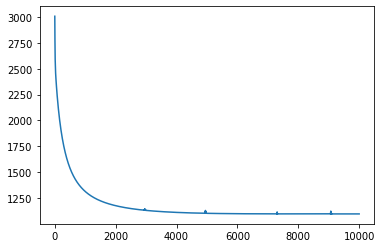

In [15]:
def minimize(posterior, n_steps: int):
    theta = t.nn.Parameter(t.randn(posterior.X.shape[1]).cuda() * 1e-3)
    optimizer = t.optim.Adam([theta], lr=1e-3)
    
    losses = []
    for _ in trange(n_steps, desc='minimization', leave=False):
        loss = -posterior.log_prob(theta[None]).squeeze(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    plt.plot(losses)
    print(losses[-1])
        
    return theta.detach().clone(), losses

theta_map, losses = minimize(lrp, 10000)

### Sampler

In [16]:
class MetropolisHastings:
    def __init__(
        self,
        target, 
        proposal_sigma: t.Tensor
    ):
        self.target = target
        self.proposal = t.distributions.Normal(t.zeros_like(proposal_sigma), proposal_sigma)
        
    def sample(self, init: t.Tensor, n_steps: int):
        chain = t.zeros(n_steps, *init.shape)
        target_prob = self.target.log_prob(init)
        
        accepted = t.zeros(len(init), dtype=t.int)
        
        for step in trange(n_steps, desc='sampling', leave=False):
            prop = init + self.proposal.sample([len(init)])
            prop_prob = self.target.log_prob(prop)
            
            flag = t.rand(len(init)).cuda().log() < prop_prob - target_prob
            
            init = t.where(flag[:, None], prop, init)
            target_prob = t.where(flag, prop_prob, target_prob)

            accepted += flag.cpu()
            chain[step] = init
            
        return chain, to_numpy(accepted) / n_steps
    
    
def subsample_chain(chain: t.Tensor, n_samples: int):
    samples = chain.reshape(-1, chain.shape[-1])
    perm = t.randperm(len(samples))
    return samples[perm[:n_samples]]

###### Sampling D

In [17]:
sampler = MetropolisHastings(lrp, t.full((X.shape[1],), 1e-3).cuda())
chain, acceptance_rate = sampler.sample(theta_map[None].repeat(128, 1), 10**5)
print(f'Acceptance rate: {acceptance_rate.mean()}')

D = subsample_chain(chain, 10**5)

Acceptance rate: 0.12238421875


#### Sampling SuperD

In [18]:
sampler = MetropolisHastings(lrp, t.full((X.shape[1],), 1e-3).cuda())
chain, acceptance_rate = sampler.sample(theta_map[None].repeat(128, 1), int(2.5 * 10**6))
print(f'Acceptance rate: {acceptance_rate.mean()}')

SuperD = subsample_chain(chain, int(2.5 * 10**6))

Acceptance rate: 0.12374529375000001


In [19]:
predictions_D = vmap_log_p(X.cpu(), D.cpu()).exp().mean(1)

In [20]:
def batched_mean_log_p(X, thetas, batch_sz: int = 2**4):
    result = t.zeros(len(X))
    for i in trange(0, len(X), batch_sz, desc='batched mean log p', leave=False):
        result[i : i + batch_sz] = vmap_log_p(X[i : i + batch_sz], thetas).exp().mean(1)
    return result
    
predictions_super_D = batched_mean_log_p(X.cpu().double(), SuperD.cpu().double())

In [54]:
D = subsample_chain(SuperD[None], 10**5)
predictions_D = batched_mean_log_p(X.cpu().double(), D.cpu().double())

### Whitened herding

In [61]:
pca = PCA().fit(to_numpy(D))
whitened_D = to_tensor(pca.transform(to_numpy(D)))

kernel = GaussianKernel(10)
whitened_herded = herd(
    whitened_D, 
    whitened_D[t.randint(0, len(whitened_D), [2])], 
    impirical_kernel_expectation(whitened_D, kernel),
    kernel,
    10**5 // 2,
)

herded = to_tensor(pca.inverse_transform(to_numpy(whitened_herded)))

### Evaluation

In [62]:
# print(predictions_D)
# print(vmap_log_p(X.cpu(), shuffled.cpu()).exp().mean(1))
# print(vmap_log_p(X.cpu(), herded.cpu()).exp().mean(1))


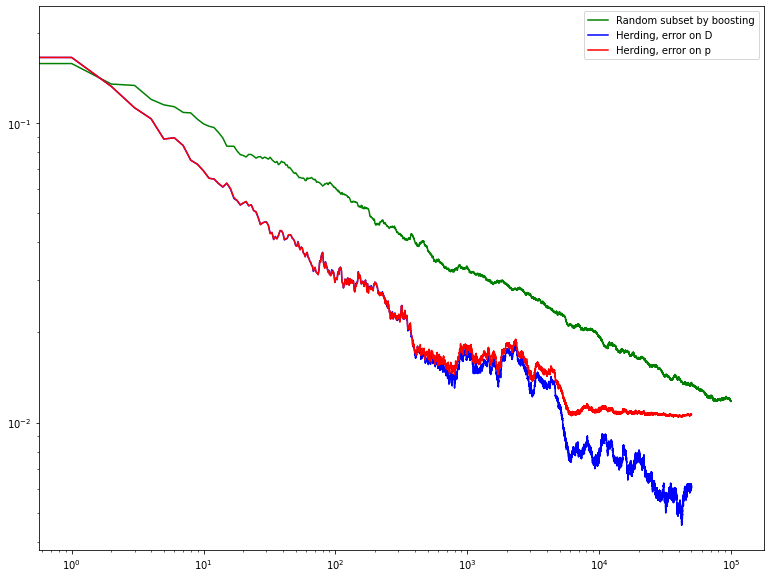

In [64]:
plt.figure(figsize=(13, 10))

shuffled = D[t.randint(0, len(D), [len(D)])]
predictions_shuffled = vmap_log_p(X.cpu(), shuffled.cpu()).exp()
plt.plot(cumulative_error(predictions_D, predictions_shuffled.T)**.5, c='g', label='Random subset by boosting')

predictions_herded = vmap_log_p(X.cpu(), herded.cpu()).exp()
plt.plot(cumulative_error(predictions_D, predictions_herded.T)**.5, c='b', label='Herding, error on D')
plt.plot(cumulative_error(predictions_super_D.cpu(), predictions_herded.T)**.5, c='r', label='Herding, error on p')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()